In [1]:
import matplotlib.pyplot as plt
import pandas as pd

### With 100 points, three cases:

1. Ideal
2. Gaussian noise
3. Uniform noise

we have created a dataset with 100 points, with 5 features each. The relation we want to investigate is

$$
2.5382 cos(x_3)+x_0^2-0.5
$$

In [2]:
import numpy as np

X = 5 * np.random.randn(100, 5)
a = 2 #weight for noise
y = 2.5382 * np.cos(X[:,3]) + X[:,0] ** 2 - 0.5 
n = y + a*np.random.randn(100,1)
u = y + a*np.random.rand(100,1)

In [4]:
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=40,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)    
    equation_file=True,
    procs=8,
)

## 1. Ideal


In [5]:
model.fit(X, y)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/julia_helpers.py:208: UserWarning: Your system's Python library is static (e.g., conda), so precompilation will be turned off. For a dynamic library, try using `pyenv` and installing with `--enable-shared`: https://github.com/pyenv/pyenv/blob/master/plugins/python-build/README.md#building-with---enable-shared.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          22.623333   
	1        2.809220                                          (x0 * x0)   
	2        0.039908                          ((x0 * x0) + -0.52674025)   
	3        0.805059                              ((x0 * x0) + cos(x3))   
	4        0.859205                ((x0 * x0) + (cos(x3) * 2.3631988))   
	5        0.697745  (((x0 * x0) + -0.27724278) + (cos(x3) * 2.3631...   
	6        0.242743  (((x0 * x0) + (cos(x3) * 2.3631988)) + sin(-0....   
	7        1.127947  (((x0 * x0) + (1.1168975 + -1.5876298)) + (cos...   
	8  >>>>  0.102498  (((((x0 * x0) + cos(x3)) + ((cos(x3) * 0.35657...   
	
	         loss  complexity  
	0  996.155200           1  
	1    3.616341           3  
	2    3.338915           5  
	3    1.492700           6  
	4    0.267717           8  
	5    0.066317          10  
	6    0.052024          11  
	7    0.016840          12  
	8    0.009104          18  
]

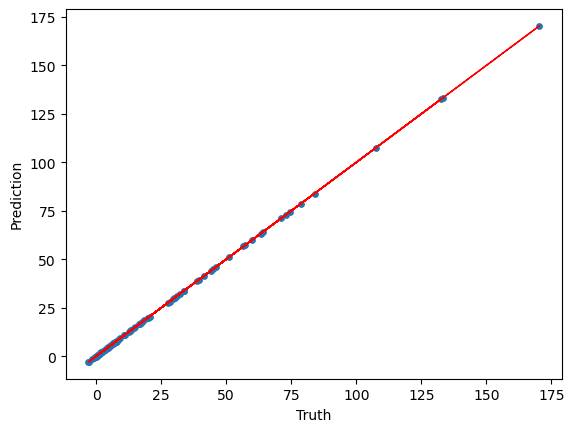

In [6]:
plt.scatter(y, model.predict(X),s=15)
plt.plot(y,y, color='r', lw=1)
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()

In [7]:
model.latex()

'x_{0}^{2} + 2.43 \\cos{\\left(x_{3} \\right)} - 0.553'

$$ x_{0}^{2} + 2.54 cos{\left(x_{3} \right)} - 0.500 $$
seems good

## 2. Gaussian noise


In [8]:
model.fit(X,n)

/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1773: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/Users/francescofarinelli/miniconda3/envs/simreg/lib/python3.11/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
